# Convolution Network

Convolution Neural Networks (CNN) have been very successful especially when modeling images. In this notebook we introduce CNNs and use Keras to learn the CIFAR10 data set

### Packages

In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras import models,layers
from tensorflow.keras.utils import Sequence
#from tensorflow.python.keras.utils import data_utils
import math
import os


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
train_dir="C:/Users/hikma/Downloads/cifar10-pngs-in-folders/cifar10/cifar10/train"
test_dir="C:/Users/hikma/Downloads/cifar10-pngs-in-folders/cifar10/cifar10/test"

img=plt.imread("C:/Users/hikma/Downloads/cifar10-pngs-in-folders/cifar10/cifar10/test/ship/0001.png")
cats=os.listdir(train_dir)
print(cats)
figs=np.array([ list(map((train_dir+"/"+cats[i]+"/").__add__,os.listdir(train_dir+"/"+cats[i]))) for i in range(0,10)])

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
figs=np.transpose(figs)
figs=np.hstack(figs)
print(figs.shape)
labels=np.array([ i%10 for i in range(0,50000)])

(50000,)


In [4]:
#class CIFAR10Sequence(data_utils.Sequence):
class CIFAR10Sequence(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        return np.array([plt.imread(filename) for filename in batch_x]),batch_y

In [5]:
dataset=CIFAR10Sequence(figs,labels,128)
(f,l)=dataset.__getitem__(0)
f.shape

(128, 32, 32, 3)

### Convolution Operations
We start with a simple example. Let I be an input image. Typically $I$ would be represented by a tensor of shape $(H,W,C)$ where $H$, $W$, and $C$ are the height, width, and color channel respectively. Therefore,  $I[h,w,c]$ refers to the value of channel $c$ in pixel $(h,w)$. Let $K$ be a filter with shape $(m,n)$ then the convolution operation produces the following tensor
\begin{align*}
T_{i,j}=\sum_c\sum_{m,n}X_{i+m,j+n,c}*K_{m,n}
\end{align*}
The above operation is illustrated in the example below. Click on the figures to see the sequence of operations.



In [6]:
(img_train,label_train),(img_test,label_test)=tf.keras.datasets.cifar10.load_data()
img_train=img_train/255.0
img_test=img_test/255.0

In [7]:
print("img_train shape={},label_train shape={}".format(img_train.shape,label_train.shape))
print("img_test shape={},label_test shape={}".format(img_test.shape,label_test.shape))


img_train shape=(50000, 32, 32, 3),label_train shape=(50000, 1)
img_test shape=(10000, 32, 32, 3),label_test shape=(10000, 1)


We have dealt with this dataset before but it is helpful to recall some of its properties. As can be seen from the above the training data contains 50000 samples and test data contains 10000 samples. The labels are numbers from 0 to 9. Below we plot the first 10 images and their corresponding labels.

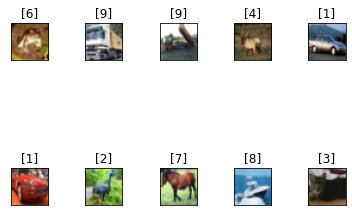

In [8]:
fig=plt.figure()
fig.tight_layout()
plt.subplots_adjust( wspace=1, hspace=1)

for i in range(0,10):
    img=img_train[i]    
    t=fig.add_subplot(2,5,i+1)
    t.set_title(str(label_train[i]))
    t.axes.get_xaxis().set_visible(False)
    t.axes.get_yaxis().set_visible(False)
    plt.imshow(img)

# Model

One can think of the input and output of convolution layers as **boxes** of the form (width,height,depth). Usually the depth of the input is the number of variables used for colors e.g. 3. The output of a Conv2D of nfilters of size (x,y) is (width-x+1, height-y+1,nfilters) where we have assumed that the stride is 1

In [9]:
def createModel():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(64, (3, 3),  activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10,activation='softmax'))
    
    return model

In [10]:
model=createModel()
#tf.keras.utils.plot_model(model,show_shapes=True)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

## Optimization

Keras can use many optimization method. In this notebook we use the __Adam__ method which can be described loosely as __adaptive__ gradient descent.

Also since the labels are __NOT__ in one_hot_encoding we use the "Sparse" version of the crossentropy loss: __SparseCategoricalCrossentropy__. Finally, if we don't specify from_logits=False then the loss function would compute softwmax before computing the loss. Since we are computing softwmax in our model already we turn this step off by specifying from_logits=False

In [11]:
# if we don't use softmax in the last layer, i.e. if the output of the
# model is NOT probabilities then use from_logits=True
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#history = model.fit(img_train,label_train, batch_size=128,epochs=10, 
#                    validation_data=(img_test, label_test))
history=model.fit(dataset,batch_size=128,epochs=10)


Epoch 1/10
391/391 [==============================] - 21s 44ms/step - loss: 1.8218 - accuracy: 0.3357
Epoch 2/10
391/391 [==============================] - 16s 40ms/step - loss: 1.3274 - accuracy: 0.5225
Epoch 3/10
391/391 [==============================] - 18s 47ms/step - loss: 1.1708 - accuracy: 0.5882
Epoch 4/10
391/391 [==============================] - 18s 45ms/step - loss: 1.0699 - accuracy: 0.6276
Epoch 5/10
391/391 [==============================] - 16s 41ms/step - loss: 0.9893 - accuracy: 0.6575
Epoch 6/10
391/391 [==============================] - 16s 40ms/step - loss: 0.9279 - accuracy: 0.6809
Epoch 7/10
391/391 [==============================] - 15s 39ms/step - loss: 0.8782 - accuracy: 0.6943
Epoch 8/10
391/391 [==============================] - 16s 42ms/step - loss: 0.8558 - accuracy: 0.7041
Epoch 9/10
391/391 [==============================] - 18s 47ms/step - loss: 0.7984 - accuracy: 0.7252
Epoch 10/10
391/391 [==============================] - 18s 45ms/step - loss: 0.776

### Testing the Accuracy

In [12]:
_,test_accuracy=model.evaluate(img_test,label_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.8862 - accuracy: 0.6913
